In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from scipy import stats
from scipy.integrate import cumulative_trapezoid
from scipy.interpolate import interp1d


@jit(nopython=True)
def RK4_ZZ(f, y0, t, args=()):
    n = len(t)
    y = np.zeros((n, len(y0)))
    Etheta = np.exp(1j*y0)
    Na = args[0]
    EA,EB = Etheta[:Na],Etheta[Na:]
    Z1a,Z2a = get_ZE12(EA)
    Z1b,Z2b = get_ZE12(EB)
    Z1as = np.zeros(n,dtype=np.complex64)
    Z1bs = np.zeros(n,dtype=np.complex64)
    Z2as = np.zeros(n,dtype=np.complex64)
    Z2bs = np.zeros(n,dtype=np.complex64)

    Z1as[0] = Z1a
    Z2as[0] = Z2a
    Z1bs[0] = Z1b
    Z2bs[0] = Z2b
    
    y[0] = y0
    
    for i in range(n - 1):
        h = t[i + 1] - t[i]
        k1,Z1a,Z1b,Z2a,Z2b = f(y[i], t[i], *args)
        k2,_,_,_,_ = f(y[i] + k1 * h / 2.0, t[i] + h / 2.0, *args)
        k3,_,_,_,_ = f(y[i] + k2 * h / 2.0, t[i] + h / 2.0, *args)
        k4,_,_,_,_ = f(y[i] + k3 * h, t[i] + h, *args)
        y[i + 1] = y[i] + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
        Z1as[i+1],Z1bs[i+1],Z2as[i+1],Z2bs[i+1] = Z1a,Z1b,Z2a,Z2b
    return y,(Z1as,Z1bs,Z2as,Z2bs)

@jit(nopython=True)
def RK4_ZZ2(f, y0, t, args=()):
    n = len(t)
    Etheta = np.exp(1j*y0)
    Na = args[0]
    EA,EB = Etheta[:Na],Etheta[Na:]
    Z1a,Z2a = get_ZE12(EA)
    Z1b,Z2b = get_ZE12(EB)
    Z1as = np.zeros(n,dtype=np.complex64)
    Z1bs = np.zeros(n,dtype=np.complex64)
    Z2as = np.zeros(n,dtype=np.complex64)
    Z2bs = np.zeros(n,dtype=np.complex64)

    Z1as[0] = Z1a
    Z2as[0] = Z2a
    Z1bs[0] = Z1b
    Z2bs[0] = Z2b
    
    y = y0
    
    for i in range(n - 1):
        h = t[i + 1] - t[i]
        k1,Z1a,Z1b,Z2a,Z2b = f(y, t[i], *args)
        k2,_,_,_,_ = f(y + k1 * h / 2.0, t[i] + h / 2.0, *args)
        k3,_,_,_,_ = f(y + k2 * h / 2.0, t[i] + h / 2.0, *args)
        k4,_,_,_,_ = f(y + k3 * h, t[i] + h, *args)
        y = y + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
        Z1as[i+1],Z1bs[i+1],Z2as[i+1],Z2bs[i+1] = Z1a,Z1b,Z2a,Z2b
    return Z1as,Z1bs,Z2as,Z2bs

@jit(nopython=True)
def get_ZE12(Etheta):
    ''' get theta and return r and theta'''
    E1 = Etheta
    E2 = E1**2
    Z1,Z2 = np.mean(E1),np.mean(E2)
    return Z1,Z2

# @jit(nopython=True)
# def Kuramoto_MF_CHIMERA(Theta,t,Na,Nb,beta,alpha,K):
#     dtheta = np.zeros(Na+Nb)

#     Etheta = np.exp(1j*Theta)
#     EA,EB = Etheta[:Na],Etheta`[Na:]
#     Z1a,Z2a = get_ZE12(EA)
#     Z1b,Z2b = get_ZE12(EB)
#     A = np.exp(-1j*alpha)
#     EA,EB = np.conjugate(EA), np.conjugate(EB)
#     ZZa =  (Z1a+beta*Z1b)
#     ZZb =  (Z1b+beta*Z1a)
#     dtheta[:Na] = K*((A*(ZZa**2-Z2a/Na - beta*Z2b/Nb))*EA*EA -(2*A/Na*ZZa)*EA).imag
#     dtheta[Na:] = K*((A*(ZZb**2-Z2b/Nb - beta*Z2a/Na))*EB*EB -(2*A/Nb*ZZb)*EB).imag
#     return dtheta,Z1a,Z1b,Z2a,Z2b

@jit(nopython=True)
def Kuramoto_MF_CHIMERA(Theta,t,Na,Nb,beta,alpha,K):
    dtheta = np.zeros(Na+Nb)

    Etheta = np.exp(1j*Theta)
    EA,EB = Etheta[:Na],Etheta[Na:]
    Z1a,Z2a = get_ZE12(EA)
    Z1b,Z2b = get_ZE12(EB)
    A = np.exp(-1j*alpha)
    EA,EB = np.conjugate(EA), np.conjugate(EB)
    ZZa =  K*(Z1a+beta*Z1b)
    ZZb =  K*(Z1b+beta*Z1a)
    dtheta[:Na] = ((A*(ZZa**2))*EA*EA).imag
    dtheta[Na:] = ((A*(ZZb**2))*EB*EB).imag
    return dtheta,Z1a,Z1b,Z2a,Z2b



import functools
import numpy as np
from scipy.optimize import root_scalar


def _vectorize_float(f):
    vectorized = np.vectorize(f, otypes=[float], signature="(),()->()")

    @functools.wraps(f)
    def wrapper(*args):
        return vectorized(*args)

    return wrapper

def dist_ab(x, a, b, eta):
    a_ = a*np.exp(1j*x)/(1-a*np.exp(1j*x))
    b_ = b*np.exp(1j*x)/(1-b*np.exp(1j*x))
    f1 = 1/(2*np.pi) * (1+ (a_+a_.conjugate()))
    f2 = 1/(2*np.pi) * (1+ (b_+b_.conjugate()))
    f = (1+eta)/2 *f1+ (1-eta)/2 *f2
    return abs(f)


def gen_dist(N,a,b,eta,seed = None):
    x = np.linspace(-np.pi/2, 3*np.pi/2, 10000)
    pdf = dist_ab(x,a,b,eta)
    cdf = cumulative_trapezoid(pdf, x, initial=0)
    cdf /= cdf[-1]  # 정규화
    quantile_func = interp1d(cdf, x, kind='nearest', fill_value='extrapolate')
    if seed != None:
        np.random.seed(seed)
        ps = np.random.uniform(0,1,N)
    else:
        ps = (np.arange(N+1)[:-1] + 1)/(N+1)
    T = quantile_func(ps)
    return T



def gen_dist2(N,a,b,eta):
    xs = np.linspace(-np.pi/2, 3*np.pi/2, 10000)
    f_ab = dist_ab(xs,a,b,eta)
    f_ab /=np.sum(f_ab)
    u = np.linspace(0,1,N+2,endpoint=True)[1:-1]
    L = np.cumsum(f_ab)
    idx = np.searchsorted(L,u)
    return xs[idx]


def gen_dist_pert_r(N,Q,eps):
    xs = np.linspace(-np.pi/2, 3*np.pi/2, 10000)
    f_r = 1/(2*np.pi) * (1-Q**2) / (1-2*Q*np.cos(2*xs) + Q**2) + eps/(np.pi) * np.cos(xs)
    f_r /=np.sum(f_r)
    u = np.linspace(0,1,N+2,endpoint=True)[1:-1]
    L = np.cumsum(f_r)
    idx = np.searchsorted(L,u)
    return xs[idx]


def gen_dist_pert_q(N,Q,eps):
    xs = np.linspace(-np.pi/2, 3*np.pi/2, 10000)
    f_r = 1/(2*np.pi) * (1-Q**2) / (1-2*Q*np.cos(2*xs) + Q**2) - eps/(np.pi) * np.cos(2*xs)
    f_r /=np.sum(f_r)
    u = np.linspace(0,1,N+2,endpoint=True)[1:-1]
    L = np.cumsum(f_r)
    idx = np.searchsorted(L,u)
    return xs[idx]



class MixtureDistribution:
    def __init__(self, distributions, weights):
        self._distributions = list(distributions)
        self._weights = list(weights)

        if not (all(w >= 0 for w in self._weights) and sum(self._weights) == 1):
            raise ValueError("Invalid weight vector.")

        if len(self._distributions) != len(self._weights):
            raise ValueError("Mixtures and weights must have the same length.")

        if len(self._distributions) < 2:
            raise ValueError("Must have at least two component distributions.")

    @_vectorize_float
    def pdf(self, x):
        return sum(w * d.pdf(x) for w, d in zip(self._weights, self._distributions))

    @_vectorize_float
    def cdf(self, x):
        return sum(w * d.cdf(x) for w, d in zip(self._weights, self._distributions))

    @_vectorize_float
    def ppf(self, p):
        bracket = [min(dist.ppf(p) for dist in self._distributions),
                   max(dist.ppf(p) for dist in self._distributions)]

        r = root_scalar(
            f=lambda x: self.cdf(x) - p,
            fprime=self.pdf,
            bracket=bracket,
            x0=0
        )
        assert r.converged
        return r.root
    # https://www.jamesatkins.com/posts/quantile-function-of-mixture-distributions-in-python/



def get_m1_m2(N,eta1,eta2):
    ps = (np.arange(N+1)[:-1] + 1)/(N+1)

    sigma1 = 1e-10
    sigma2 = 0.50790452
    shift = 0*np.pi/8
    # m1 = MixtureDistribution([stats.norm(0,sigma1), stats.norm(np.pi,sigma1)], [1/2 + eta1/2, 1/2 - eta1/2])
    m2 = MixtureDistribution([stats.norm(0+shift,sigma2), stats.norm(np.pi+shift,sigma2)], [1/2 + eta2/2, 1/2 - eta2/2])
    Peak_0_N = int((1/2 *(1 + eta1))*N)
    Peak_pi_N = N - Peak_0_N
    theta1 = np.r_[np.zeros(Peak_0_N),np.pi*np.ones(Peak_pi_N)]
    theta2 = m2.ppf(ps)
    Q2_init = np.mean(np.exp(2j*theta2))
    print(abs(Q2_init),np.angle(Q2_init))
    # theta1 = m1.ppf(ps)
    Theta = np.r_[theta1,theta2]
    return Theta

@jit(nopython=True)
def RK4(f, y0, t, args=()):
    n = len(t)
    y = np.zeros((n,len(y0)))
    y[0] = y0

    for i in range(n - 1):
        h = t[i + 1] - t[i]
        k1 = f(y[i], t[i], *args)
        k2 = f(y[i] + k1 * h / 2.0, t[i] + h / 2.0, *args)
        k3 = f(y[i] + k2 * h / 2.0, t[i] + h / 2.0, *args)
        k4 = f(y[i] + k3 * h, t[i] + h, *args)
        y[i + 1] = y[i] + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return y
# a1real,a1imag,b1real,b1imag,a2real,a2imag,b2real,b2imag
@jit(nopython=True)
def dZ_dt(Zs,t,alpha,beta,eta1,eta2):
    a1real,a1imag,b1real,b1imag,a2real,a2imag,b2real,b2imag = Zs
    a1 = a1real + 1j*a1imag
    a2 = a2real + 1j*a2imag
    b1 = b1real + 1j*b1imag
    b2 = b2real + 1j*b2imag
    Z11 = 1/2 * (np.conj(a1)+np.conj(b1)) + eta1/2 * (np.conj(a1)-np.conj(b1))
    Z12 = 1/2 * (np.conj(a2)+np.conj(b2)) + eta2/2 * (np.conj(a2)-np.conj(b2))
    H1 = (Z11**2 + 2*beta*Z11*Z12 + beta**2*Z12**2)
    H2 = (Z12**2 + 2*beta*Z11*Z12 + beta**2*Z11**2)
    
    da1 = 1/2 *(np.conj(H1)*np.conj(a1)*np.exp(1j*alpha) - H1*a1**3*np.exp(-1j*alpha) )
    db1 = 1/2 *(np.conj(H1)*np.conj(b1)*np.exp(1j*alpha) - H1*b1**3*np.exp(-1j*alpha) )
    da2 = 1/2 *(np.conj(H2)*np.conj(a2)*np.exp(1j*alpha) - H2*a2**3*np.exp(-1j*alpha) )
    db2 = 1/2 *(np.conj(H2)*np.conj(b2)*np.exp(1j*alpha) - H2*b2**3*np.exp(-1j*alpha) )
    return np.array([da1.real,da1.imag,db1.real,db1.imag,da2.real,da2.imag,db2.real,db2.imag])


# a1real,a1imag,b1real,b1imag,a2real,a2imag,b2real,b2imag
@jit(nopython=True)
def dZ_dt(Zs,t,alpha,beta,eta1,eta2):
    a1real,a1imag,b1real,b1imag,a2real,a2imag,b2real,b2imag = Zs
    a1 = a1real + 1j*a1imag
    a2 = a2real + 1j*a2imag
    b1 = b1real + 1j*b1imag
    b2 = b2real + 1j*b2imag
    Z11 = 1/2 * (np.conj(a1)+np.conj(b1)) + eta1/2 * (np.conj(a1)-np.conj(b1))
    Z12 = 1/2 * (np.conj(a2)+np.conj(b2)) + eta2/2 * (np.conj(a2)-np.conj(b2))
    H1 = (Z11**2 + 2*beta*Z11*Z12 + beta**2*Z12**2)
    H2 = (Z12**2 + 2*beta*Z11*Z12 + beta**2*Z11**2)
    
    da1 = 1/2 *(np.conj(H1)*np.conj(a1)*np.exp(1j*alpha) - H1*a1**3*np.exp(-1j*alpha) )
    db1 = 1/2 *(np.conj(H1)*np.conj(b1)*np.exp(1j*alpha) - H1*b1**3*np.exp(-1j*alpha) )
    da2 = 1/2 *(np.conj(H2)*np.conj(a2)*np.exp(1j*alpha) - H2*a2**3*np.exp(-1j*alpha) )
    db2 = 1/2 *(np.conj(H2)*np.conj(b2)*np.exp(1j*alpha) - H2*b2**3*np.exp(-1j*alpha) )
    return np.array([da1.real,da1.imag, db1.real,db1.imag, da2.real,da2.imag, db2.real,db2.imag])

@jit(nopython=True)
def dZ2_dt(Zs,t,alpha,beta,eta1,eta2):
    a1real,a1imag,b1real,b1imag,a2real,a2imag,b2real,b2imag = Zs
    a1 = a1real + 1j*a1imag
    a2 = a2real + 1j*a2imag
    b1 = b1real + 1j*b1imag
    b2 = b2real + 1j*b2imag
    Z11 = 1/2 * (np.conj(a1)+np.conj(b1)) + eta1/2 * (np.conj(a1)-np.conj(b1))
    Z12 = 1/2 * (np.conj(a2)+np.conj(b2)) + eta2/2 * (np.conj(a2)-np.conj(b2))
    H1 = (Z11**2 + 2*beta*Z11*Z12 + beta**2*Z12**2)
    H2 = (Z12**2 + 2*beta*Z11*Z12 + beta**2*Z11**2)
    
    da1 = 1/2 *(np.conj(H1)/a1*np.exp(1j*alpha) - H1*a1**3*np.exp(-1j*alpha) )
    db1 = 1/2 *(np.conj(H1)/b1*np.exp(1j*alpha) - H1*b1**3*np.exp(-1j*alpha) )
    da2 = 1/2 *(np.conj(H2)/a2*np.exp(1j*alpha) - H2*a2**3*np.exp(-1j*alpha) )
    db2 = 1/2 *(np.conj(H2)/b2*np.exp(1j*alpha) - H2*b2**3*np.exp(-1j*alpha) )
    return np.array([da1.real,da1.imag, db1.real,db1.imag, da2.real,da2.imag, db2.real,db2.imag])

@jit(nopython=True)
def dZ3_dt(Zs,t,alpha,beta,eta1,eta2):
    a1real,a1imag,b1real,b1imag,a2real,a2imag,b2real,b2imag = Zs
    a1 = a1real + 1j*a1imag
    a2 = a2real + 1j*a2imag
    b1 = b1real + 1j*b1imag
    b2 = b2real + 1j*b2imag
    Z11 = np.conj(a1)
    Z12 = np.conj(a2)
    H1 = (Z11**2 + 2*beta*Z11*Z12 + beta**2*Z12**2)
    H2 = (Z12**2 + 2*beta*Z11*Z12 + beta**2*Z11**2)
    
    da1 = 1/2 *(np.conj(H1)*np.conj(a1)*np.exp(1j*alpha) - H1*a1**3*np.exp(-1j*alpha) )
    db1 = (np.conj(H1)*np.exp(1j*alpha) - H1*b1**2*np.exp(-1j*alpha) )
    da2 = 1/2 *(np.conj(H2)*np.conj(a2)*np.exp(1j*alpha) - H2*a2**3*np.exp(-1j*alpha) )
    db2 = (np.conj(H2)*np.exp(1j*alpha) - H2*b2**2*np.exp(-1j*alpha) )
    return np.array([da1.real,da1.imag, db1.real,db1.imag, da2.real,da2.imag, db2.real,db2.imag])

# Use OA ansatz
@jit(nopython=True)
def dZ4_dt(Zs,t,alpha,beta,eta1,eta2):
    a1real,a1imag,b1real,b1imag,a2real,a2imag,b2real,b2imag = Zs
    a1 = a1real + 1j*a1imag
    a2 = a2real + 1j*a2imag
    b1 = b1real + 1j*b1imag
    b2 = b2real + 1j*b2imag
    
    
    Z11 = eta1 * np.conj(a1)
    Z12 = eta2 * np.conj(a2)
    
    H1 = (Z11**2 + 2*beta*Z11*Z12 + beta**2*Z12**2)
    H2 = (Z12**2 + 2*beta*Z11*Z12 + beta**2*Z11**2)
    A = np.exp(1j*alpha)
    AS = np.exp(-1j*alpha)
    da1 = 1/2 *(np.conj(H1)/a1*A - H1*a1**3*AS )
    da2 = 1/2 *(np.conj(H2)/a2*A - H2*a2**3*AS )
    db1 = 1/2 *(np.conj(H1)/b1*A - H1*a1**3*AS )
    db2 = 1/2 *(np.conj(H2)/b2*A - H2*a2**3*AS )
    
    return np.array([da1.real,da1.imag, db1.real,db1.imag, da2.real,da2.imag, db2.real,db2.imag])
# Use OA ansatz
@jit(nopython=True)
def dZ5_dt(Zs,t,alpha,beta,eta1,eta2):
    a1real,a1imag,b1real,b1imag,a2real,a2imag,b2real,b2imag = Zs
    a1 = a1real + 1j*a1imag
    a2 = a2real + 1j*a2imag
    b1 = b1real + 1j*b1imag
    b2 = b2real + 1j*b2imag
    
    
    Z11 = eta1 * np.conj(a1)
    Z12 = eta2 * np.conj(a2)
    
    H1 = (Z11**2 + 2*beta*Z11*Z12 + beta**2*Z12**2)
    H2 = (Z12**2 + 2*beta*Z11*Z12 + beta**2*Z11**2)
    A = np.exp(1j*alpha)
    AS = np.exp(-1j*alpha)
    da1 = 1/2 *(np.conj(H1)*np.conj(a1)*A - H1*a1**3*AS )
    da2 = 1/2 *(np.conj(H2)*np.conj(a2)*A - H2*a2**3*AS )
    db1 = 1/2 *(np.conj(H1)/b1*A - H1*a1**3*AS )
    db2 = 1/2 *(np.conj(H2)/b2*A - H2*a2**3*AS )
    
    return np.array([da1.real,da1.imag, db1.real,db1.imag, da2.real,da2.imag, db2.real,db2.imag])



def to_complex(Zs):
    a1real,a1imag,b1real,b1imag,a2real,a2imag,b2real,b2imag = Zs.T
    a1 = a1real + 1j*a1imag
    a2 = a2real + 1j*a2imag
    b1 = b1real + 1j*b1imag
    b2 = b2real + 1j*b2imag
    return a1,b1,a2,b2

def get_RQ_MOA(Q1,Q2,alpha,beta,eta1,eta2,shift=0,t_end = 5000):
    A1 = Q1
    A2 = np.sqrt(Q2)
    a1 =  A1 *np.exp(0j)
    b1 =  a1 * np.exp(np.pi*1j)
    a2 =  A2*np.exp(shift*1j)
    b2 =  a2* np.exp(np.pi*1j)


    t = np.arange(0,t_end,0.1)
    Zs = RK4(dZ_dt,np.array([a1.real,a1.imag,b1.real,b1.imag,a2.real,a2.imag,b2.real,b2.imag]),t,args=(alpha,beta,eta1,eta2))
    a1s,b1s,a2s,b2s = to_complex(Zs)

    RZ1 = 1/2 * (np.conj(a1s)+np.conj(b1s)) + eta1/2 * (np.conj(a1s)-np.conj(b1s))
    QZ1 = 1/2 * (np.conj(a1s)**2+np.conj(b1s)**2) + eta1/2 * (np.conj(a1s)**2-np.conj(b1s)**2)
    RZ2 = 1/2 * (np.conj(a2s)+np.conj(b2s)) + eta2/2 * (np.conj(a2s)-np.conj(b2s))
    QZ2 = 1/2 * (np.conj(a2s)**2+np.conj(b2s)**2) + eta2/2 * (np.conj(a2s)**2-np.conj(b2s)**2)

    R1s = np.abs(RZ1)
    R2s = np.abs(RZ2)
    Q1s = np.abs(QZ1)
    Q2s = np.abs(QZ2)
    return R1s,R2s,Q1s,Q2s,t


def get_RQ_MOA2(Q1,Q2,alpha,beta,eta1,eta2,shift=0,t_end = 5000,dt=0.1):
    A1 = Q1
    A2 = np.sqrt(Q2)
    a1 =  A1 *np.exp(0j)
    b1 =  a1 * np.exp(np.pi*1j)
    a2 =  A2*np.exp(shift*1j)
    b2 =  a2* np.exp(np.pi*1j)


    t = np.arange(0,t_end,dt)
    Zs = RK4(dZ2_dt,np.array([a1.real,a1.imag,b1.real,b1.imag,a2.real,a2.imag,b2.real,b2.imag]),t,args=(alpha,beta,eta1,eta2))
    a1s,b1s,a2s,b2s = to_complex(Zs)

    RZ1 = 1/2 * (np.conj(a1s)+np.conj(b1s)) + eta1/2 * (np.conj(a1s)-np.conj(b1s))
    QZ1 = 1/2 * (np.conj(a1s)**2+np.conj(b1s)**2) + eta1/2 * (np.conj(a1s)**2-np.conj(b1s)**2)
    RZ2 = 1/2 * (np.conj(a2s)+np.conj(b2s)) + eta2/2 * (np.conj(a2s)-np.conj(b2s))
    QZ2 = 1/2 * (np.conj(a2s)**2+np.conj(b2s)**2) + eta2/2 * (np.conj(a2s)**2-np.conj(b2s)**2)

    R1s = np.abs(RZ1)
    R2s = np.abs(RZ2)
    Q1s = np.abs(QZ1)
    Q2s = np.abs(QZ2)
    return R1s,R2s,Q1s,Q2s,t



def get_R_simul(N,eta1,eta2,alpha,beta,t_end = 5000,dt=0.1):
    N1 = N2 = N
    Theta = get_m1_m2(N,eta1,eta2)
    t = np.arange(0,t_end,dt)
    thetas,(Z1as,Z1bs,Z2as,Z2bs) = RK4_ZZ(Kuramoto_MF_CHIMERA,Theta.copy(),t,args=(N1,N2,beta,alpha,1))
    R1_S = np.abs(Z1as)
    R2_S = np.abs(Z1bs)
    Q1_S = np.abs(Z2as)
    Q2_S = np.abs(Z2bs)
    return R1_S,R2_S,Q1_S,Q2_S,t



def get_R_simul_wf(Q1,Q2,N,eta1,eta2,alpha,beta,shift=0,t_end = 5000):
    N1 = N2 = N
    A1 = np.sqrt(Q1)
    A2 = np.sqrt(Q2)
    a1 =  A1 *np.exp(0j)
    b1 =  a1 * np.exp(np.pi*1j)
    a2 =  A2*np.exp(shift*1j)
    b2 =  a2* np.exp(np.pi*1j)
    T1 = np.r_[np.zeros(int((1/2 + eta1/2)*N)),np.pi* np.ones(N - int((1/2 + eta1/2)*N))]
    T2 = gen_dist(N,a2,b2,eta2)
    Theta =  np.r_[T1,T2]
    t = np.arange(0,t_end,0.1)
    thetas,(Z1as,Z1bs,Z2as,Z2bs) = RK4_ZZ(Kuramoto_MF_CHIMERA,Theta.copy(),t,args=(N1,N2,beta,alpha,1))
    R1_S = np.abs(Z1as)
    R2_S = np.abs(Z1bs)
    Q1_S = np.abs(Z2as)
    Q2_S = np.abs(Z2bs)
    return R1_S,R2_S,Q1_S,Q2_S,t



def get_R_simul_wfT(Q1,Q2,N,eta1,eta2,alpha,beta,shift=0,t_end = 5000,dt=0.1, seed = None):
    N1 = N2 = N
    A1 = np.sqrt(Q1)
    A2 = np.sqrt(Q2)
    a1 =  A1 *np.exp(0j)
    b1 =  a1 * np.exp(np.pi*1j)
    a2 =  A2*np.exp(shift*1j)
    b2 =  a2* np.exp(np.pi*1j)
    T1 = np.r_[np.zeros(int((1/2 + eta1/2)*N)),np.pi* np.ones(N - int((1/2 + eta1/2)*N))]
    T2 = gen_dist(N,a2,b2,eta2,seed = seed)
    Theta =  np.r_[T1,T2]
    t = np.arange(0,t_end,dt)
    thetas,(Z1as,Z1bs,Z2as,Z2bs) = RK4_ZZ(Kuramoto_MF_CHIMERA,Theta.copy(),t,args=(N1,N2,beta,alpha,1))
    R1_S = np.abs(Z1as)
    R2_S = np.abs(Z1bs)
    Q1_S = np.abs(Z2as)
    Q2_S = np.abs(Z2bs)
    return R1_S,R2_S,Q1_S,Q2_S,t,thetas



def get_R_simul_wf2(Q1,Q2,N,eta1,eta2,alpha,beta,shift=0,t_end = 5000):
    N1 = N2 = N
    A1 = np.sqrt(Q1)
    A2 = np.sqrt(Q2)
    a1 =  A1 *np.exp(0j)
    b1 =  a1 * np.exp(np.pi*1j)
    a2 =  A2*np.exp(shift*1j)
    b2 =  a2* np.exp(np.pi*1j)
    T1 = np.r_[np.zeros(int((1/2 + eta1/2)*N)),np.pi* np.ones(N - int((1/2 + eta1/2)*N))]
    T2 = gen_dist2(N,a2,b2,eta2)
    Theta =  np.r_[T1,T2]
    t = np.arange(0,t_end,0.1)
    Z1as,Z1bs,Z2as,Z2bs = RK4_ZZ2(Kuramoto_MF_CHIMERA,Theta.copy(),t,args=(N1,N2,beta,alpha,1))
    R1_S = np.abs(Z1as[::1000])
    R2_S = np.abs(Z1bs[::1000])
    Q1_S = np.abs(Z2as[::1000])
    Q2_S = np.abs(Z2bs[::1000])
    return R1_S,R2_S,Q1_S,Q2_S,t



def get_R_sim_pert(Q2,N,eta1,eps,alpha,beta,pertb='r',shift=0,t_end = 5000, seed = None):
    N1 = N2 = N
    T1 = np.r_[np.zeros(int((1/2 + eta1/2)*N)),np.pi* np.ones(N - int((1/2 + eta1/2)*N))]
    if pertb == 'r':
        T2 = gen_dist_pert_r(N,Q2,eps)
    else:
        T2 = gen_dist_pert_q(N,Q2,eps)
    Theta =  np.r_[T1,T2]
    t = np.arange(0,t_end,0.1)
    thetas,(Z1as,Z1bs,Z2as,Z2bs) = RK4_ZZ(Kuramoto_MF_CHIMERA,Theta.copy(),t,args=(N1,N2,beta,alpha,1))
    R1_S = np.abs(Z1as)
    R2_S = np.abs(Z1bs)
    Q1_S = np.abs(Z2as)
    Q2_S = np.abs(Z2bs)
    return R1_S,R2_S,Q1_S,Q2_S,t,thetas

def get_RQ_MOA3(Q1,Q2,alpha,beta,eta1,eta2,shift=0,t_end = 5000,dt=0.1):
    a1 =  eta1*np.sqrt(Q1)*np.exp(0j)
    b1 =  Q1*np.exp(0j)
    a2 =  eta1*np.sqrt(Q2)*np.exp(0j)
    b2 =  Q2*np.exp(0j)


    t = np.arange(0,t_end,dt)
    Zs = RK4(dZ3_dt,np.array([a1.real,a1.imag,b1.real,b1.imag,a2.real,a2.imag,b2.real,b2.imag]),t,args=(alpha,beta,eta1,eta2))
    a1s,b1s,a2s,b2s = to_complex(Zs)

    RZ1 = eta1*np.conj(a1s)
    QZ1 = np.conj(b1s)
    RZ2 = eta2*np.conj(a2s)
    QZ2 = np.conj(b2s)

    R1s = np.abs(RZ1)
    R2s = np.abs(RZ2)
    Q1s = np.abs(QZ1)
    Q2s = np.abs(QZ2)
    return R1s,R2s,Q1s,Q2s,t


def get_RQ_MOA4(Q1,Q2,alpha,beta,eta1,eta2,shift=0,t_end = 5000,dt=0.1):
    a1 =  np.sqrt(Q1)*np.exp(0j)
    b1 =  np.sqrt(Q1)*np.exp(0j)
    a2 =  np.sqrt(Q2)*np.exp(0j)
    b2 =  np.sqrt(Q2)*np.exp(0j)


    t = np.arange(0,t_end,dt)
    Zs = RK4(dZ4_dt,np.array([a1.real,a1.imag,b1.real,b1.imag,a2.real,a2.imag,b2.real,b2.imag]),t,args=(alpha,beta,eta1,eta2))
    a1s,b1s,a2s,b2s = to_complex(Zs)

    RZ1 = eta1*np.conj(a1s)
    QZ1 = np.conj(b1s)**2
    RZ2 = eta2*np.conj(a2s)
    QZ2 = np.conj(b2s)**2

    R1s = np.abs(RZ1)
    R2s = np.abs(RZ2)
    Q1s = np.abs(QZ1)
    Q2s = np.abs(QZ2)
    return R1s,R2s,Q1s,Q2s,t

def get_RQ_MOA5(Q1,Q2,alpha,beta,eta1,eta2,shift=0,t_end = 5000,dt=0.1):
    a1 =  np.sqrt(Q1)*np.exp(0j)
    b1 =  np.sqrt(Q1)*np.exp(0j)
    a2 =  np.sqrt(Q2)*np.exp(0j)
    b2 =  np.sqrt(Q2)*np.exp(0j)


    t = np.arange(0,t_end,dt)
    Zs = RK4(dZ5_dt,np.array([a1.real,a1.imag,b1.real,b1.imag,a2.real,a2.imag,b2.real,b2.imag]),t,args=(alpha,beta,eta1,eta2))
    a1s,b1s,a2s,b2s = to_complex(Zs)

    RZ1 = eta1*np.conj(a1s)
    QZ1 = np.conj(b1s)**2
    RZ2 = eta2*np.conj(a2s)
    QZ2 = np.conj(b2s)**2

    R1s = np.abs(RZ1)
    R2s = np.abs(RZ2)
    Q1s = np.abs(QZ1)
    Q2s = np.abs(QZ2)
    return R1s,R2s,Q1s,Q2s,t

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from parfor import parfor

In [7]:
alpha = 0.2
beta = 0.2
eta1 = 0.1
eta2 = 0.0
shift = 0
N = 10000
Q1 = 1
Q2 = 0.6
t_end = 20_001
t = np.arange(0,t_end,0.1)


In [8]:
N1 = N2 = N
A1 = np.sqrt(Q1)
A2 = np.sqrt(Q2)
a1 =  A1 *np.exp(0j)
b1 =  a1 * np.exp(np.pi*1j)
a2 =  A2*np.exp(shift*1j)
b2 =  a2* np.exp(np.pi*1j)
T1 = np.r_[np.zeros(int((1/2 + eta1/2)*N)),np.pi* np.ones(N - int((1/2 + eta1/2)*N))]
T2 = gen_dist(N,a2,b2,eta2)
Theta =  np.r_[T1,T2]

(array([ 51.,  51.,  56.,  60.,  69.,  81., 100., 131., 181., 268., 421.,
        645., 785., 643., 417., 266., 178., 130., 100.,  81.,  69.,  60.,
         55.,  52.,  50.,  50.,  52.,  55.,  60.,  69.,  81., 100., 130.,
        178., 266., 417., 643., 785., 645., 421., 268., 181., 131., 100.,
         81.,  69.,  60.,  56.,  51.,  51.]),
 array([-1.5682828 , -1.44271964, -1.31715647, -1.19159331, -1.06603014,
        -0.94046698, -0.81490381, -0.68934065, -0.56377748, -0.43821432,
        -0.31265115, -0.18708798, -0.06152482,  0.06403835,  0.18960151,
         0.31516468,  0.44072784,  0.56629101,  0.69185417,  0.81741734,
         0.9429805 ,  1.06854367,  1.19410683,  1.31967   ,  1.44523316,
         1.57079633,  1.69635949,  1.82192266,  1.94748582,  2.07304899,
         2.19861215,  2.32417532,  2.44973848,  2.57530165,  2.70086481,
         2.82642798,  2.95199114,  3.07755431,  3.20311747,  3.32868064,
         3.4542438 ,  3.57980697,  3.70537013,  3.8309333 ,  3.95649646,
 

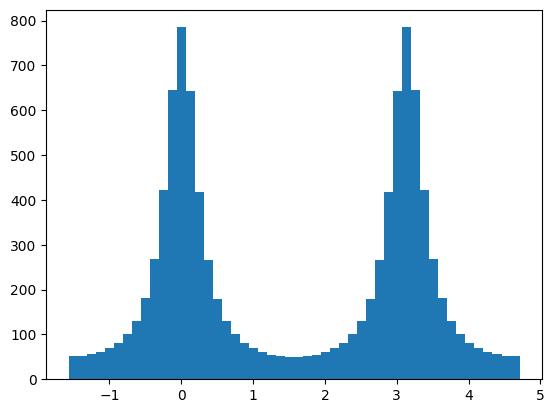

In [9]:
plt.hist(T2,bins=50)

In [10]:
betas

NameError: name 'betas' is not defined

In [11]:
N1,N2 = N,N
K = 1
alphas = np.linspace(0,np.pi/2,50)
betas = np.linspace(0,1,51)[1:]


R1s = []
R2s = []
Q1s = []
Q2s = []

for beta in tqdm(betas[20:]):

    @parfor(alphas,args=(beta,),bar=False,n_processes=50)
    def ParFOR(alpha,beta):
        (Z1as,Z1bs,Z2as,Z2bs) = RK4_ZZ2(Kuramoto_MF_CHIMERA,Theta.copy(),t,args=(N1,N2,beta,alpha,K))
        R1 = np.abs(Z1as)[::100]
        R2 = np.abs(Z1bs)[::100]
        Q1 = np.abs(Z2as)[::100]
        Q2 = np.abs(Z2bs)[::100]
        
        return R1,R2,Q1,Q2
    R1,R2,Q1,Q2 = zip(*ParFOR)

    np.savez(f'SIMUL/beta = {beta} N = {N}',Q1=Q1,Q2=Q2,R1=R1,R2=R2)




  0%|          | 0/30 [00:00<?, ?it/s]

In [21]:
for beta in betas[:20]:
    Q1s = []
    Q2s = []
    R1s = []
    R2s = []
    for alpha in alphas:
        A = np.load(f'SIMUL/SIMUL/N={N}_alpha={alpha:.3f}_beta={beta:.3f}.npz')
        Q1s.append(A['Q1'])
        Q2s.append(A['Q2'])
        R1s.append(A['R1'])
        R2s.append(A['R2'])
    np.savez(f'SIMUL/beta = {beta} N = {N}',Q1=Q1s,Q2=Q2s,R1=R1s,R2=R2s)

In [29]:
Q1s = np.zeros((50,50,len(A['Q1'][0])))
Q2s = np.zeros((50,50,len(A['Q2'][0])))
R1s = np.zeros((50,50,len(A['R1'][0])))
R2s = np.zeros((50,50,len(A['R2'][0])))
for i,beta in enumerate(betas):
    A =  np.load(f'SIMUL/beta = {beta} N = {N}.npz')
    Q1s[i,:,:] = A['Q1']
    Q2s[i,:,:] = A['Q2']
    R2s[i,:,:] = A['R2']
    R1s[i,:,:] = A['R1']

In [35]:
np.savez(f'N = {N} Simulation result',Q1=Q1s,Q2=Q2s,R1=R1s,R2=R2s,beta=betas,alpha=alphas,t=t[::100])

In [47]:
t_temp = t[::100]
len(t_temp)

2001

(0.02, 1.0)

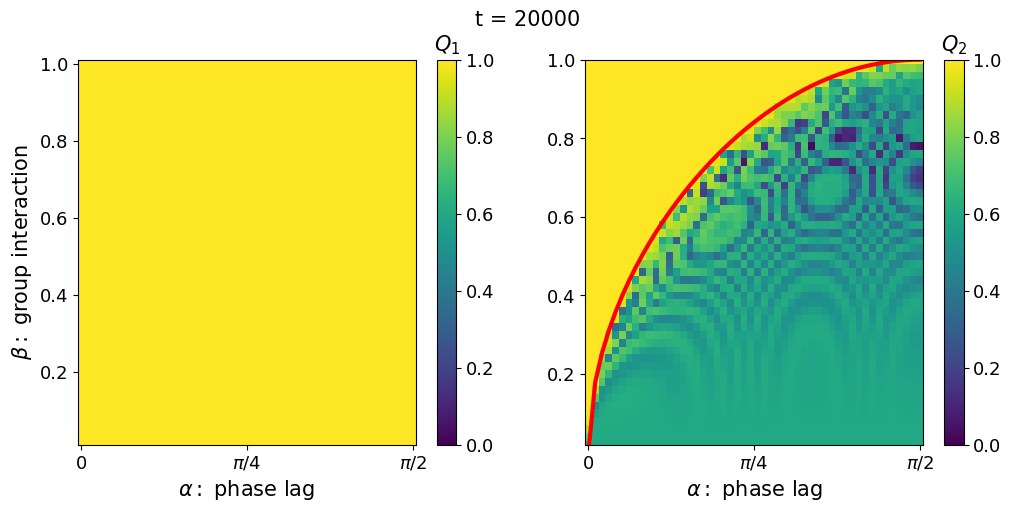

In [45]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,5),dpi=100)

index = -1
im1 = ax1.pcolormesh(alphas,betas,Q1s[:,:,index],vmin=0.0, vmax=1)
ax1.set_aspect('auto')
cbar1 = fig.colorbar(im1,ax=ax1,shrink=1)
cbar1.ax.set_title(r'$Q_1$',fontsize=15)
cbar1.ax.tick_params(labelsize=13)
plt.sca(ax1)
plt.xlabel(r'$\alpha:$ phase lag',fontsize = 15)
plt.ylabel(r'$\beta:$ group interaction',fontsize = 15)
plt.xticks([0,np.pi/4,np.pi/2],[0,'$\pi/4$','$\pi/2$'],fontsize=13)
plt.yticks(fontsize=13)


im2 = ax2.pcolormesh(alphas,betas,Q2s[:,:,index],vmin=0.0, vmax=1)
ax2.set_aspect('auto')
ax2.plot(alphas,np.sqrt(np.sin(alphas)),color='red',lw=3)


cbar2 = fig.colorbar(im2,ax=ax2,shrink=1)
cbar2.ax.tick_params(labelsize=13)
cbar2.ax.set_title(r'$Q_2$',fontsize=15)

text = fig.suptitle(rf't = {t_temp[index] :.0f}',fontsize=15)
plt.sca(ax2)
plt.xlabel(r'$\alpha:$ phase lag',fontsize = 15)
plt.xticks([0,np.pi/4,np.pi/2],[0,'$\pi/4$','$\pi/2$'],fontsize=13)
plt.yticks(fontsize=13);
plt.ylim(betas[0],1)



In [48]:
def get_ani(idx):
    im1.set_array(Q1s[:,:,idx])
    im2.set_array(Q2s[:,:,idx])
    text.set_text(rf't = ${t_temp[idx] :.0f}$')

len(t)
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128
%config InlineBackend.figure_format = 'retina'
idxs=  np.arange(000,2001,10)
ani = FuncAnimation(fig,get_ani,frames=idxs,interval=50)
len(t)
# HTML(ani.to_jshtml())
ani.save(rf'HIGH ORDER CHIMERA/Simulation  Q1 Q2 N = {N} Q2,eta1 = {eta1},eta2 = {eta2},shift = {shift/np.pi}pi,Q2_init = 0.1.mp4',dpi=300)

In [ ]:
fig,(ax1) = plt.subplots(1,1,figsize=(6,5),dpi=100)

index = 0
im1 = ax1.pcolormesh(alphas,betas,Q2s[:,:,index],vmin=0.0, vmax=1)
ax1.set_aspect('auto')
text = ax1.set_title(rf't = {t_temp[index] :.0f}',fontsize=15)

cbar1 = fig.colorbar(im1,ax=ax1,shrink=1)
cbar1.ax.set_title(r'$Q_2$',fontsize=15)
cbar1.ax.tick_params(labelsize=13)
plt.sca(ax1)
plt.xlabel(r'$\alpha:$ phase lag',fontsize = 15)
plt.ylabel(r'$\beta:$ group interaction',fontsize = 15)
plt.xticks([0,np.pi/4,np.pi/2],[0,'$\pi/4$','$\pi/2$'],fontsize=13)
plt.yticks(fontsize=13)


In [49]:
from Simul import get_RQ_MOA4,get_RQ_MOA5,get_RQ_MOA2,get_R_simul_wfT
import numpy as np
import matplotlib.pyplot as plt

In [58]:
N1,N2 = N,N
K = 1
alphas = np.linspace(0,np.pi/2,100)
betas = np.linspace(0,1,101)[1:]

Q_init = 0.6
for beta in tqdm(betas[20:]):

    @parfor(alphas,args=(beta,),bar=False)
    def ParFOR(alpha,beta):
        Z1as,Z1bs,Z2as,Z2bs,t = get_RQ_MOA4(1,Q_init,alpha=alpha,beta=beta,eta1=eta1,eta2=eta2,shift=shift,t_end=t_end,dt=0.1)
        R1 = np.abs(Z1as)[::100]
        R2 = np.abs(Z1bs)[::100]
        Q1 = np.abs(Z2as)[::100]
        Q2 = np.abs(Z2bs)[::100]
        
        return R1,R2,Q1,Q2
    R1,R2,Q1,Q2 = zip(*ParFOR)

    np.savez(f'SIMUL OA/beta = {beta} N = {N}',Q1=Q1,Q2=Q2,R1=R1,R2=R2)




  0%|          | 0/80 [00:00<?, ?it/s]

In [59]:
Q1s = np.zeros((100,100,len(A['Q1'][0])))
Q2s = np.zeros((100,100,len(A['Q2'][0])))
R1s = np.zeros((100,100,len(A['R1'][0])))
R2s = np.zeros((100,100,len(A['R2'][0])))
for i,beta in enumerate(betas):
    A =  np.load(f'SIMUL OA/beta = {beta} N = {N}.npz')
    Q1s[i,:,:] = A['Q1']
    Q2s[i,:,:] = A['Q2']
    R2s[i,:,:] = A['R2']
    R1s[i,:,:] = A['R1']

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0')])

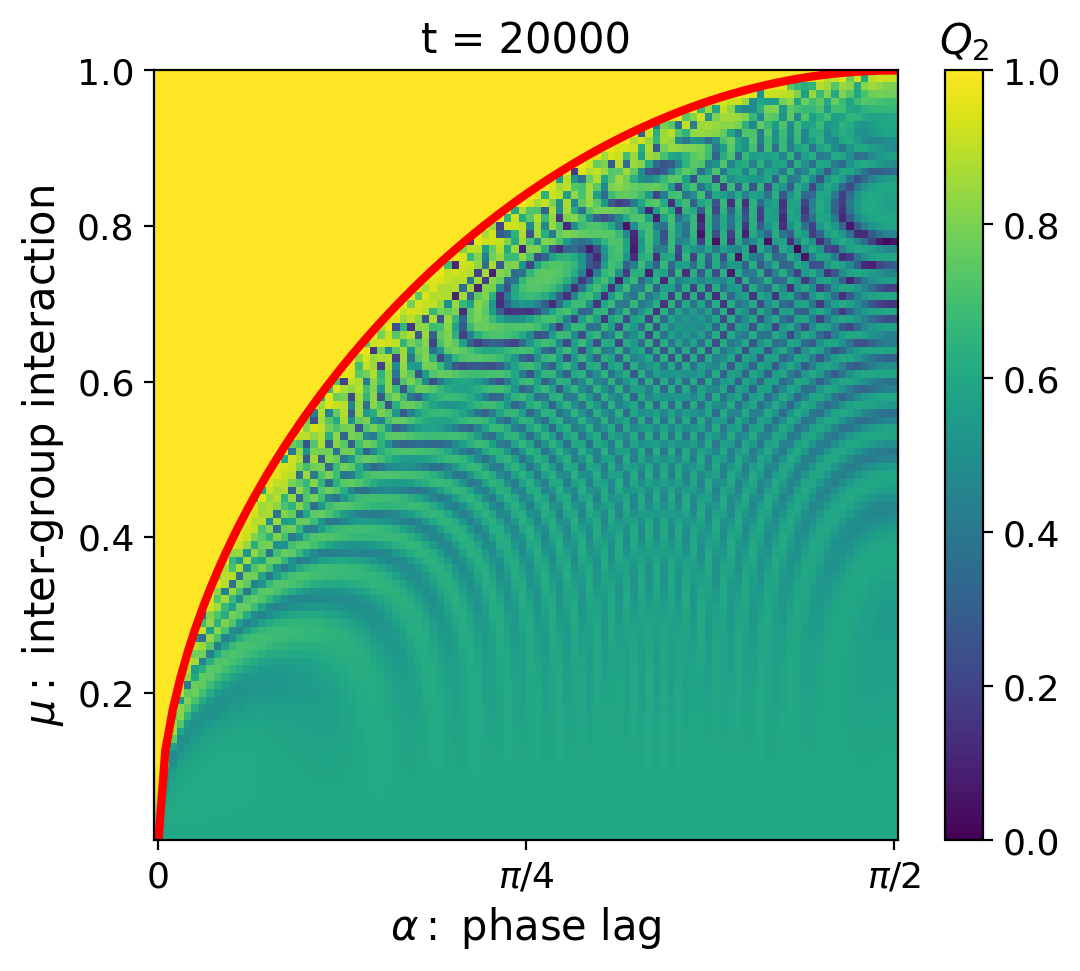

In [63]:
fig,(ax1) = plt.subplots(1,1,figsize=(6,5),dpi=100)

index = -1
im1 = ax1.pcolormesh(alphas,betas,Q2s[:,:,index],vmin=0.0, vmax=1)
ax1.set_aspect('auto')
text = ax1.set_title(rf't = {t_temp[index] :.0f}',fontsize=15)

cbar1 = fig.colorbar(im1,ax=ax1,shrink=1)
cbar1.ax.set_title(r'$Q_2$',fontsize=15)
cbar1.ax.tick_params(labelsize=13)
plt.sca(ax1)
ax1.plot(alphas,np.sqrt(np.sin(alphas)),color='red',lw=3)

plt.xlabel(r'$\alpha:$ phase lag',fontsize = 15)
plt.ylim(betas[0],1)
plt.ylabel(r'$\mu:$ inter-group interaction',fontsize = 15)
plt.xticks([0,np.pi/4,np.pi/2],[0,'$\pi/4$','$\pi/2$'],fontsize=13)
plt.yticks(fontsize=13)


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0')])

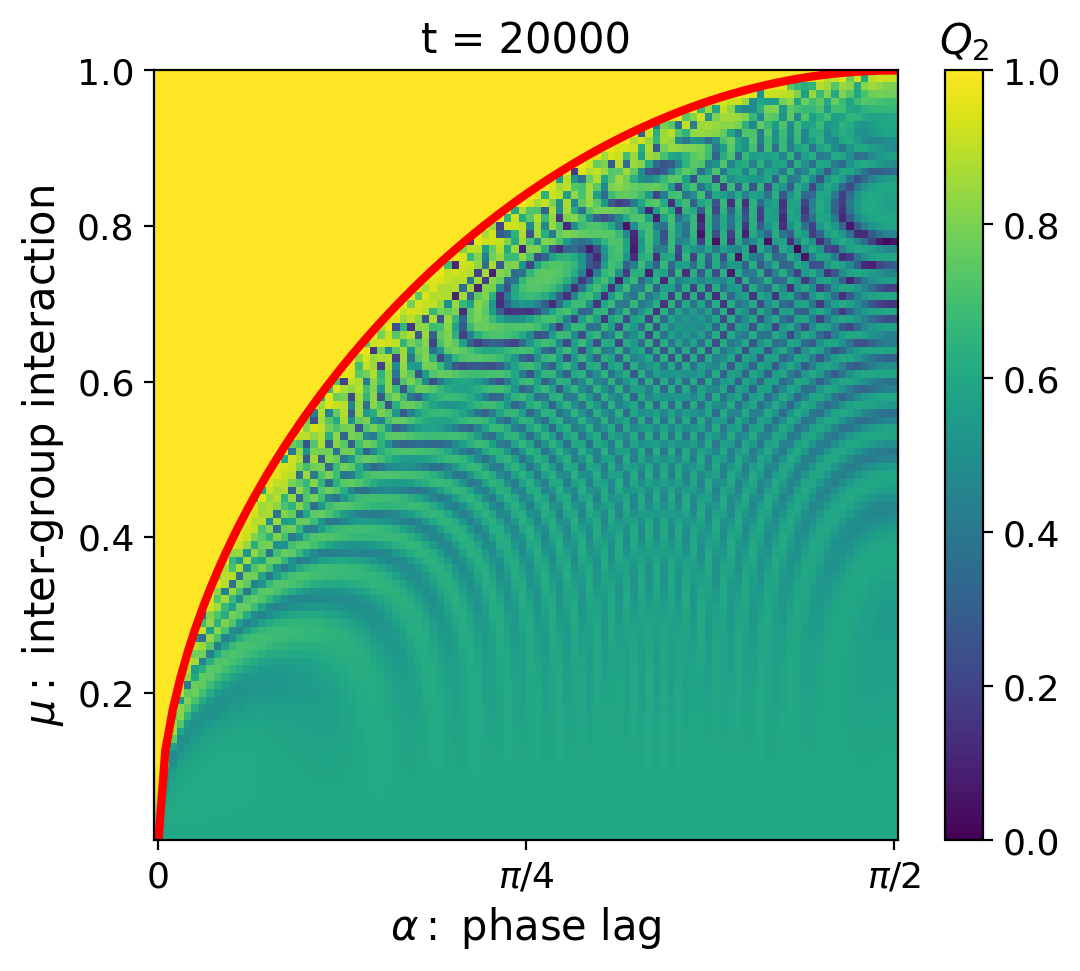

In [69]:
fig,(ax1) = plt.subplots(1,1,figsize=(6,5),dpi=100)

index = -1
im1 = ax1.pcolormesh(alphas,betas,Q2s[:,:,index],vmin=0.0, vmax=1)
ax1.set_aspect('auto')
text = ax1.set_title(rf't = {t_temp[index] :.0f}',fontsize=15)

cbar1 = fig.colorbar(im1,ax=ax1,shrink=1)
cbar1.ax.set_title(r'$Q_2$',fontsize=15)
cbar1.ax.tick_params(labelsize=13)
plt.sca(ax1)
ax1.plot(alphas,np.sqrt(np.sin(alphas)),color='red',lw=3)

plt.xlabel(r'$\alpha:$ phase lag',fontsize = 15)
plt.ylim(betas[0],1)
plt.ylabel(r'$\mu:$ inter-group interaction',fontsize = 15)
plt.xticks([0,np.pi/4,np.pi/2],[0,'$\pi/4$','$\pi/2$'],fontsize=13)
plt.yticks(fontsize=13)


In [61]:
def get_ani(idx):
    im1.set_array(Q2s[:,:,idx])
    text.set_text(rf't = ${t_temp[idx] :.0f}$')

len(t)
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128
%config InlineBackend.figure_format = 'retina'
idxs=  np.arange(000,2001,10)
ani = FuncAnimation(fig,get_ani,frames=idxs,interval=50)
len(t)
# HTML(ani.to_jshtml())
ani.save(rf'HIGH ORDER CHIMERA/OA Q1 Q2, eta1 = {eta1},eta2 = {eta2},shift = {shift/np.pi}pi,Q2_init = 0.6.mp4',dpi=300)

In [92]:
alpha = 0.2
beta = 0.8
Z1as,Z1bs,Z2as,Z2bs,t = get_RQ_MOA4(1,Q_init,alpha=alpha,beta=beta,eta1=eta1,eta2=eta2,shift=shift,t_end=t_end,dt=0.1)
R1 = np.abs(Z1as)
R2 = np.abs(Z1bs)
Q1 = np.abs(Z2as)
Q2 = np.abs(Z2bs)

In [93]:
(Z1as,Z1bs,Z2as,Z2bs) = RK4_ZZ2(Kuramoto_MF_CHIMERA,Theta.copy(),t,args=(N1,N2,beta,alpha,K))
R1_sim = np.abs(Z1as)
R2_sim = np.abs(Z1bs)
Q1_sim = np.abs(Z2as)
Q2_sim = np.abs(Z2bs)

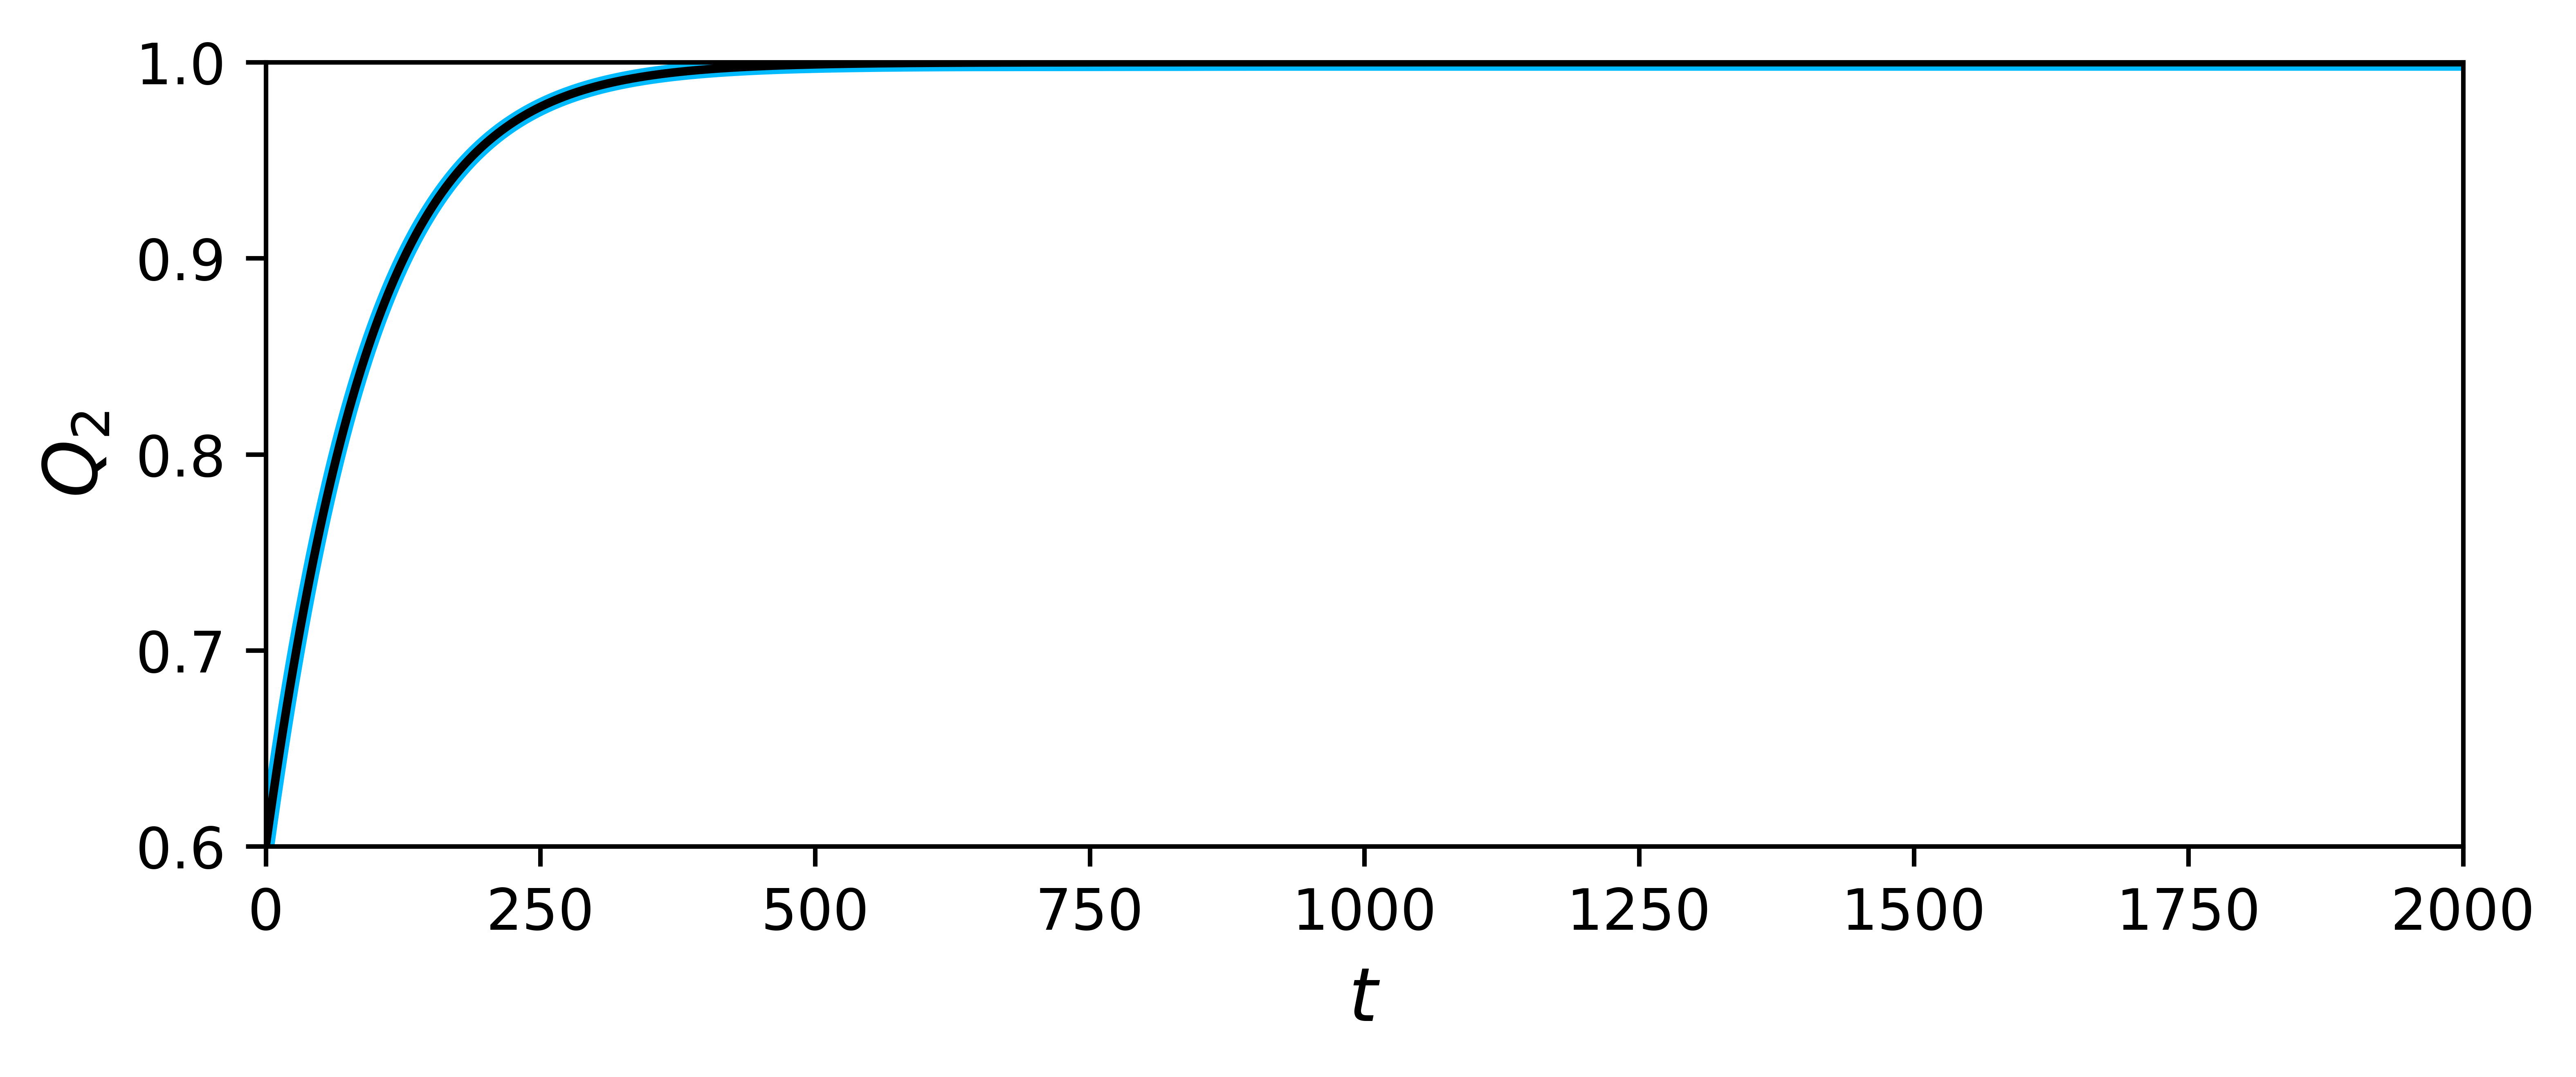

In [ ]:
plt.figure(dpi=500)
plt.subplot(211)
plt.plot(t,Q2_sim,color='#00BAFF',lw=3)
plt.plot(t,Q2,color='k')
plt.xlim(0,2000)
plt.ylim(0.6,1)
plt.xlabel(r'$t$',fontsize=13)
plt.ylabel(r'$Q_2$',fontsize=13)
plt.tight_layout()
